In [2]:
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D

from keras import callbacks 
from keras.constraints import maxnorm
import keras
from sklearn.model_selection import KFold

In [6]:
import os
path, dirs, files = next(os.walk("D:\\code\\Jupyter\\climate_project\\New Data\\profiles"))
file_count = len(files)
print('The number of profiles:',file_count)

The number of profiles: 4000


In [7]:
#retrieve data
num = 4000 # number of profiles
nvza = 12 # number of channels
nsza=6

# get spatial dimension
fname = "D:\\code\\Jupyter\\climate_project\\New Data\\profiles/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

In [8]:
#get the averaged reflectance from the dataset 
fname_r = "data_reflectance.h5"
hf_r = h5py.File(fname_r, 'r')
r=hf_r['dataset_reflectance']
r.shape

(4000, 82)

In [9]:
#get the averaged reflectance from the dataset 
fname_c = "data_cot.h5"
hf_c = h5py.File(fname_c, 'r')
c=hf_c['dataset_cot']
c.shape

(4000, 82)

In [10]:
c=c[:]
r=r[:]

In [11]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800
print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')


# spatial slicing dimensions
os =82 # output size
ts = os # input size 



train_size: 3200 profiles
test_size: 800 profiles


In [12]:
ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()

bsize = 16
eps = 4000

input_layer = tf.keras.layers.Input(shape=(ts,1),name='Input')
lstm=tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True,input_shape=(ts,1))(input_layer) 
lstm=tf.keras.layers.LSTM(units=64, activation='tanh')(lstm) 
output = tf.keras.layers.Dense(os,activation='relu')(lstm)


model = tf.keras.models.Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])

model.summary()



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 82, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 82, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 82)                5330      
Total params: 55,250
Trainable params: 55,250
Non-trainable params: 0
_________________________________________________________________


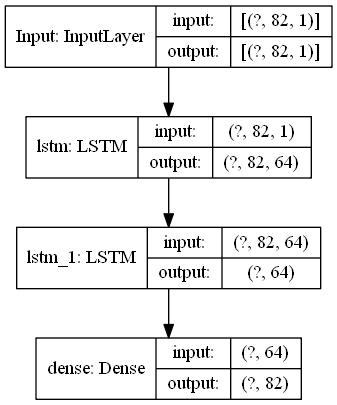

In [13]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

In [34]:
#Bi-LSTM model-------------------------------------------------------------------------------------------------
def eval_model(train_image, test_image, train_label, test_label):
    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()

    bsize = 16
    eps = 4000

    input_layer = tf.keras.layers.Input(shape=(ts,1),name='Input')
    
    lstm=tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True,input_shape=(ts,1))(input_layer) 
    lstm=tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True)(lstm) 
    lstm=tf.keras.layers.LSTM(units=96, activation='tanh',return_sequences = True)(lstm) 
    flat=tf.keras.layers.Flatten()(lstm)

    output = tf.keras.layers.Dense(os,activation='relu')(flat)


    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])

    model.summary()


    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]

    return model,rmse,mse,history,predictions

In [35]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds) #800

X_train=np.zeros((5,800*4,ts))
y_train=np.zeros((5,ratio*(n_folds-1),os))
X_test=np.zeros((n_folds,ratio,ts))
y_test=np.zeros((n_folds,ratio,os))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index]
    y_train[count], y_test[count] = c[train_index], c[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 800  801  802 ... 3997 3998 3999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

In [36]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 82, 1)]           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 82, 64)            16896     
_________________________________________________________________
lstm_23 (LSTM)               (None, 82, 64)            33024     
_________________________________________________________________
lstm_24 (LSTM)               (None, 82, 96)            61824     
_________________________________________________________________
flatten_3 (Flatten)          (None, 7872)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 82)                645586    
Total params: 757,330
Trainable params: 757,330
Non-trainable params: 0
_______________________________________________

175/175 [==============================] - 9s 51ms/step - loss: 0.3240 - mean_squared_error: 0.3240 - root_mean_squared_error: 0.5692 - val_loss: 0.5977 - val_mean_squared_error: 0.5977 - val_root_mean_squared_error: 0.7731
Epoch 65/4000
175/175 [==============================] - 9s 51ms/step - loss: 0.3056 - mean_squared_error: 0.3056 - root_mean_squared_error: 0.5528 - val_loss: 0.5986 - val_mean_squared_error: 0.5986 - val_root_mean_squared_error: 0.7737
Epoch 66/4000
175/175 [==============================] - 9s 50ms/step - loss: 0.3050 - mean_squared_error: 0.3050 - root_mean_squared_error: 0.5523 - val_loss: 0.6081 - val_mean_squared_error: 0.6081 - val_root_mean_squared_error: 0.7798
Epoch 67/4000
175/175 [==============================] - 9s 50ms/step - loss: 0.2942 - mean_squared_error: 0.2942 - root_mean_squared_error: 0.5424 - val_loss: 0.5905 - val_mean_squared_error: 0.5905 - val_root_mean_squared_error: 0.7685
Epoch 68/4000
175/175 [==============================] - 9s 50

175/175 [==============================] - 9s 50ms/step - loss: 3.7499 - mean_squared_error: 3.7499 - root_mean_squared_error: 1.9365 - val_loss: 3.9918 - val_mean_squared_error: 3.9918 - val_root_mean_squared_error: 1.9980
Epoch 17/4000
175/175 [==============================] - 9s 49ms/step - loss: 3.4578 - mean_squared_error: 3.4578 - root_mean_squared_error: 1.8595 - val_loss: 3.8844 - val_mean_squared_error: 3.8844 - val_root_mean_squared_error: 1.9709
Epoch 18/4000
175/175 [==============================] - 9s 49ms/step - loss: 3.0970 - mean_squared_error: 3.0970 - root_mean_squared_error: 1.7598 - val_loss: 3.3921 - val_mean_squared_error: 3.3921 - val_root_mean_squared_error: 1.8418
Epoch 19/4000
175/175 [==============================] - 9s 49ms/step - loss: 2.8320 - mean_squared_error: 2.8320 - root_mean_squared_error: 1.6828 - val_loss: 3.2904 - val_mean_squared_error: 3.2904 - val_root_mean_squared_error: 1.8139
Epoch 20/4000
175/175 [==============================] - 9s 50

175/175 [==============================] - 9s 49ms/step - loss: 0.2100 - mean_squared_error: 0.2100 - root_mean_squared_error: 0.4582 - val_loss: 0.6027 - val_mean_squared_error: 0.6027 - val_root_mean_squared_error: 0.7764
Epoch 85/4000
175/175 [==============================] - 9s 50ms/step - loss: 0.2037 - mean_squared_error: 0.2037 - root_mean_squared_error: 0.4514 - val_loss: 0.6162 - val_mean_squared_error: 0.6162 - val_root_mean_squared_error: 0.7850
Epoch 86/4000
175/175 [==============================] - 9s 49ms/step - loss: 0.2026 - mean_squared_error: 0.2026 - root_mean_squared_error: 0.4501 - val_loss: 0.6101 - val_mean_squared_error: 0.6101 - val_root_mean_squared_error: 0.7811
Epoch 87/4000
175/175 [==============================] - 9s 50ms/step - loss: 0.1935 - mean_squared_error: 0.1935 - root_mean_squared_error: 0.4398 - val_loss: 0.6264 - val_mean_squared_error: 0.6264 - val_root_mean_squared_error: 0.7915
Epoch 88/4000
175/175 [==============================] - 9s 53

Epoch 10/4000
175/175 [==============================] - 9s 50ms/step - loss: 6.6499 - mean_squared_error: 6.6499 - root_mean_squared_error: 2.5787 - val_loss: 6.4908 - val_mean_squared_error: 6.4908 - val_root_mean_squared_error: 2.5477
Epoch 11/4000
175/175 [==============================] - 9s 51ms/step - loss: 5.9338 - mean_squared_error: 5.9338 - root_mean_squared_error: 2.4359 - val_loss: 6.0475 - val_mean_squared_error: 6.0475 - val_root_mean_squared_error: 2.4592
Epoch 12/4000
175/175 [==============================] - 9s 51ms/step - loss: 5.4151 - mean_squared_error: 5.4151 - root_mean_squared_error: 2.3270 - val_loss: 5.4706 - val_mean_squared_error: 5.4706 - val_root_mean_squared_error: 2.3389
Epoch 13/4000
175/175 [==============================] - 9s 50ms/step - loss: 4.9959 - mean_squared_error: 4.9959 - root_mean_squared_error: 2.2352 - val_loss: 5.1757 - val_mean_squared_error: 5.1757 - val_root_mean_squared_error: 2.2750
Epoch 14/4000
175/175 [=========================

175/175 [==============================] - 9s 51ms/step - loss: 0.1968 - mean_squared_error: 0.1968 - root_mean_squared_error: 0.4437 - val_loss: 0.5514 - val_mean_squared_error: 0.5514 - val_root_mean_squared_error: 0.7426
Epoch 79/4000
175/175 [==============================] - 9s 50ms/step - loss: 0.1981 - mean_squared_error: 0.1981 - root_mean_squared_error: 0.4451 - val_loss: 0.5555 - val_mean_squared_error: 0.5555 - val_root_mean_squared_error: 0.7453
Epoch 80/4000
175/175 [==============================] - 9s 52ms/step - loss: 0.1936 - mean_squared_error: 0.1936 - root_mean_squared_error: 0.4400 - val_loss: 0.5588 - val_mean_squared_error: 0.5588 - val_root_mean_squared_error: 0.7476
Epoch 81/4000
175/175 [==============================] - 9s 51ms/step - loss: 0.1927 - mean_squared_error: 0.1927 - root_mean_squared_error: 0.4390 - val_loss: 0.5337 - val_mean_squared_error: 0.5337 - val_root_mean_squared_error: 0.7306
Epoch 82/4000
175/175 [==============================] - 9s 51

Epoch 7/4000
175/175 [==============================] - 9s 50ms/step - loss: 8.8504 - mean_squared_error: 8.8504 - root_mean_squared_error: 2.9750 - val_loss: 8.2982 - val_mean_squared_error: 8.2982 - val_root_mean_squared_error: 2.8807
Epoch 8/4000
175/175 [==============================] - 9s 50ms/step - loss: 7.3967 - mean_squared_error: 7.3967 - root_mean_squared_error: 2.7197 - val_loss: 7.2442 - val_mean_squared_error: 7.2442 - val_root_mean_squared_error: 2.6915
Epoch 9/4000
175/175 [==============================] - 9s 52ms/step - loss: 6.3488 - mean_squared_error: 6.3488 - root_mean_squared_error: 2.5197 - val_loss: 6.3578 - val_mean_squared_error: 6.3578 - val_root_mean_squared_error: 2.5215
Epoch 10/4000
175/175 [==============================] - 9s 51ms/step - loss: 5.7439 - mean_squared_error: 5.7439 - root_mean_squared_error: 2.3966 - val_loss: 5.8923 - val_mean_squared_error: 5.8923 - val_root_mean_squared_error: 2.4274
Epoch 11/4000
175/175 [============================

175/175 [==============================] - 9s 52ms/step - loss: 0.2232 - mean_squared_error: 0.2232 - root_mean_squared_error: 0.4724 - val_loss: 0.5448 - val_mean_squared_error: 0.5448 - val_root_mean_squared_error: 0.7381
Epoch 76/4000
175/175 [==============================] - 9s 52ms/step - loss: 0.2212 - mean_squared_error: 0.2212 - root_mean_squared_error: 0.4703 - val_loss: 0.5642 - val_mean_squared_error: 0.5642 - val_root_mean_squared_error: 0.7511
Epoch 77/4000
175/175 [==============================] - 9s 52ms/step - loss: 0.2126 - mean_squared_error: 0.2126 - root_mean_squared_error: 0.4610 - val_loss: 0.5446 - val_mean_squared_error: 0.5446 - val_root_mean_squared_error: 0.7380
Epoch 78/4000
175/175 [==============================] - 9s 51ms/step - loss: 0.2027 - mean_squared_error: 0.2027 - root_mean_squared_error: 0.4502 - val_loss: 0.5454 - val_mean_squared_error: 0.5454 - val_root_mean_squared_error: 0.7385
Epoch 79/4000
175/175 [==============================] - 9s 51

Epoch 19/4000
175/175 [==============================] - 9s 51ms/step - loss: 3.2971 - mean_squared_error: 3.2971 - root_mean_squared_error: 1.8158 - val_loss: 3.5372 - val_mean_squared_error: 3.5372 - val_root_mean_squared_error: 1.8808
Epoch 20/4000
175/175 [==============================] - 9s 51ms/step - loss: 3.1090 - mean_squared_error: 3.1090 - root_mean_squared_error: 1.7632 - val_loss: 3.4636 - val_mean_squared_error: 3.4636 - val_root_mean_squared_error: 1.8611
Epoch 21/4000
175/175 [==============================] - 9s 51ms/step - loss: 2.8465 - mean_squared_error: 2.8465 - root_mean_squared_error: 1.6872 - val_loss: 3.2805 - val_mean_squared_error: 3.2805 - val_root_mean_squared_error: 1.8112
Epoch 22/4000
175/175 [==============================] - 9s 52ms/step - loss: 2.6561 - mean_squared_error: 2.6561 - root_mean_squared_error: 1.6298 - val_loss: 3.1272 - val_mean_squared_error: 3.1272 - val_root_mean_squared_error: 1.7684
Epoch 23/4000
175/175 [=========================

175/175 [==============================] - 9s 52ms/step - loss: 0.1788 - mean_squared_error: 0.1788 - root_mean_squared_error: 0.4228 - val_loss: 0.6714 - val_mean_squared_error: 0.6714 - val_root_mean_squared_error: 0.8194
Epoch 88/4000
175/175 [==============================] - 9s 52ms/step - loss: 0.1786 - mean_squared_error: 0.1786 - root_mean_squared_error: 0.4226 - val_loss: 0.6885 - val_mean_squared_error: 0.6885 - val_root_mean_squared_error: 0.8298
Epoch 89/4000
175/175 [==============================] - 9s 51ms/step - loss: 0.1755 - mean_squared_error: 0.1755 - root_mean_squared_error: 0.4190 - val_loss: 0.6795 - val_mean_squared_error: 0.6795 - val_root_mean_squared_error: 0.8243
Epoch 90/4000
175/175 [==============================] - 9s 51ms/step - loss: 0.1639 - mean_squared_error: 0.1639 - root_mean_squared_error: 0.4049 - val_loss: 0.6929 - val_mean_squared_error: 0.6929 - val_root_mean_squared_error: 0.8324
Epoch 91/4000
175/175 [==============================] - 9s 51

In [37]:
#quantitative result
print(' Test MSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print(' Test RMSE %.4f with standard devisation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

 Test MSE 0.5805 with standard devisation (0.0544)
 Test RMSE 0.7611 with standard devisation (0.0355)


In [38]:
predictions.shape

(800, 82)

In [39]:
cv_scores #MSE

[0.5932955145835876,
 0.5934019684791565,
 0.5308495759963989,
 0.5158802270889282,
 0.6689133644104004]

In [40]:
cv_scores2 #RMSE

[0.7702566981315613,
 0.7703258991241455,
 0.7285942435264587,
 0.7182480096817017,
 0.8178712725639343]

The optimal number of epochs is 72


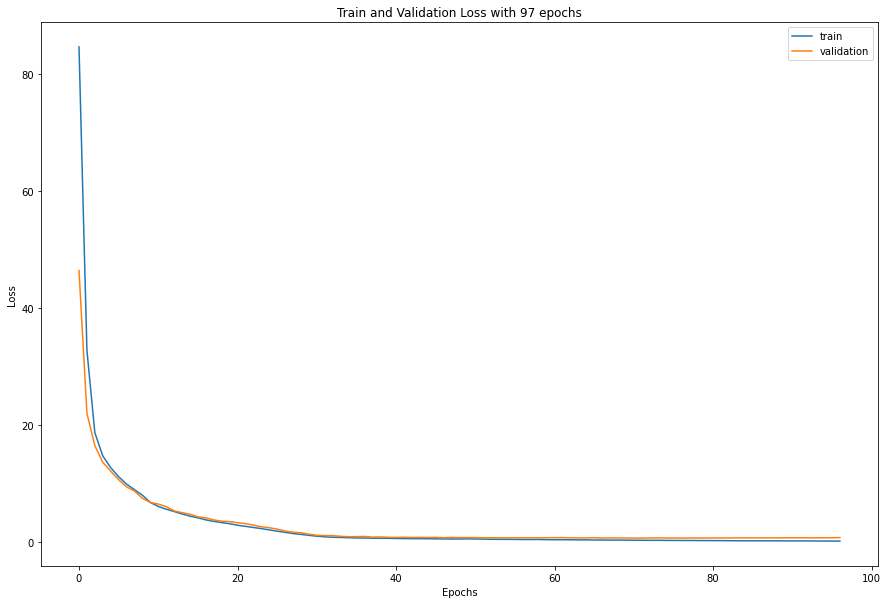

In [41]:
patience=25
# plot training and validation history
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [44]:
predict1=np.zeros((os)) #82
predict1=predictions[-3]
    
predict2=np.zeros((os))
predict2=predictions[-2]
    
predict3=np.zeros((os))
predict3=predictions[-1]

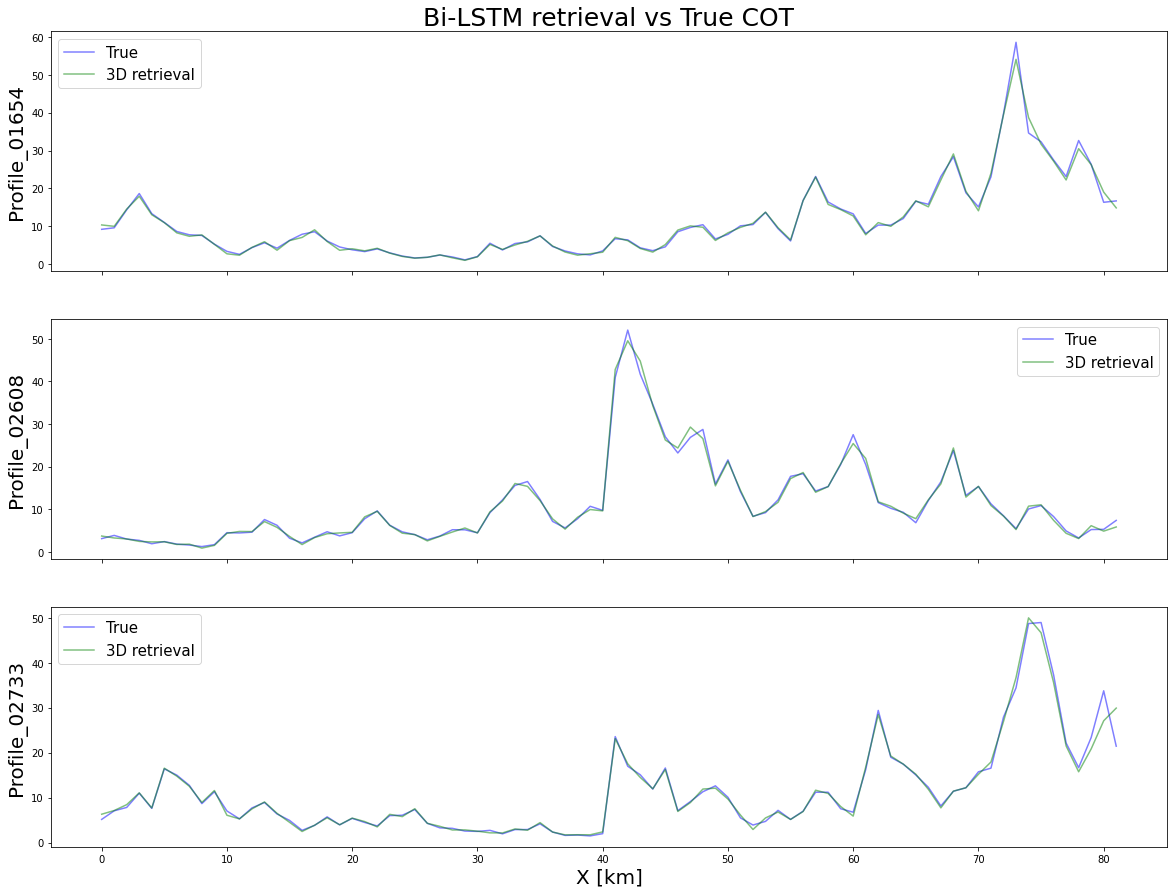

In [48]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/5folds_Bi-LSTM SZA=60 VZA=0 "+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM retrieval vs True COT", fontsize=25)
ax.plot(range(82),c[num-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "3D retrieval"],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "3D retrieval"],fontsize=15)
ax.set_ylabel(r"Profile_02608",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1].T,alpha=0.5,color="blue")
ax.plot(range(82),predict3,alpha=0.5,color="green")
ax.legend(["True", "3D retrieval"],fontsize=15)
ax.set_ylabel(r"Profile_02733",fontsize=20)  
ax.set_xlabel('X [km]', fontsize=20)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

# Plotting across predicted 82 COT values

In [46]:
std=[]
mean=[]

for k in range(os):
    tmp=[]
    for j in range(test_size):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))

    std.append(np.std(tmp))
    mean.append(np.mean(tmp))
std=np.array(std)
mean=np.array(mean)

In [43]:
len(mean)

82

In [45]:
len(std)

82

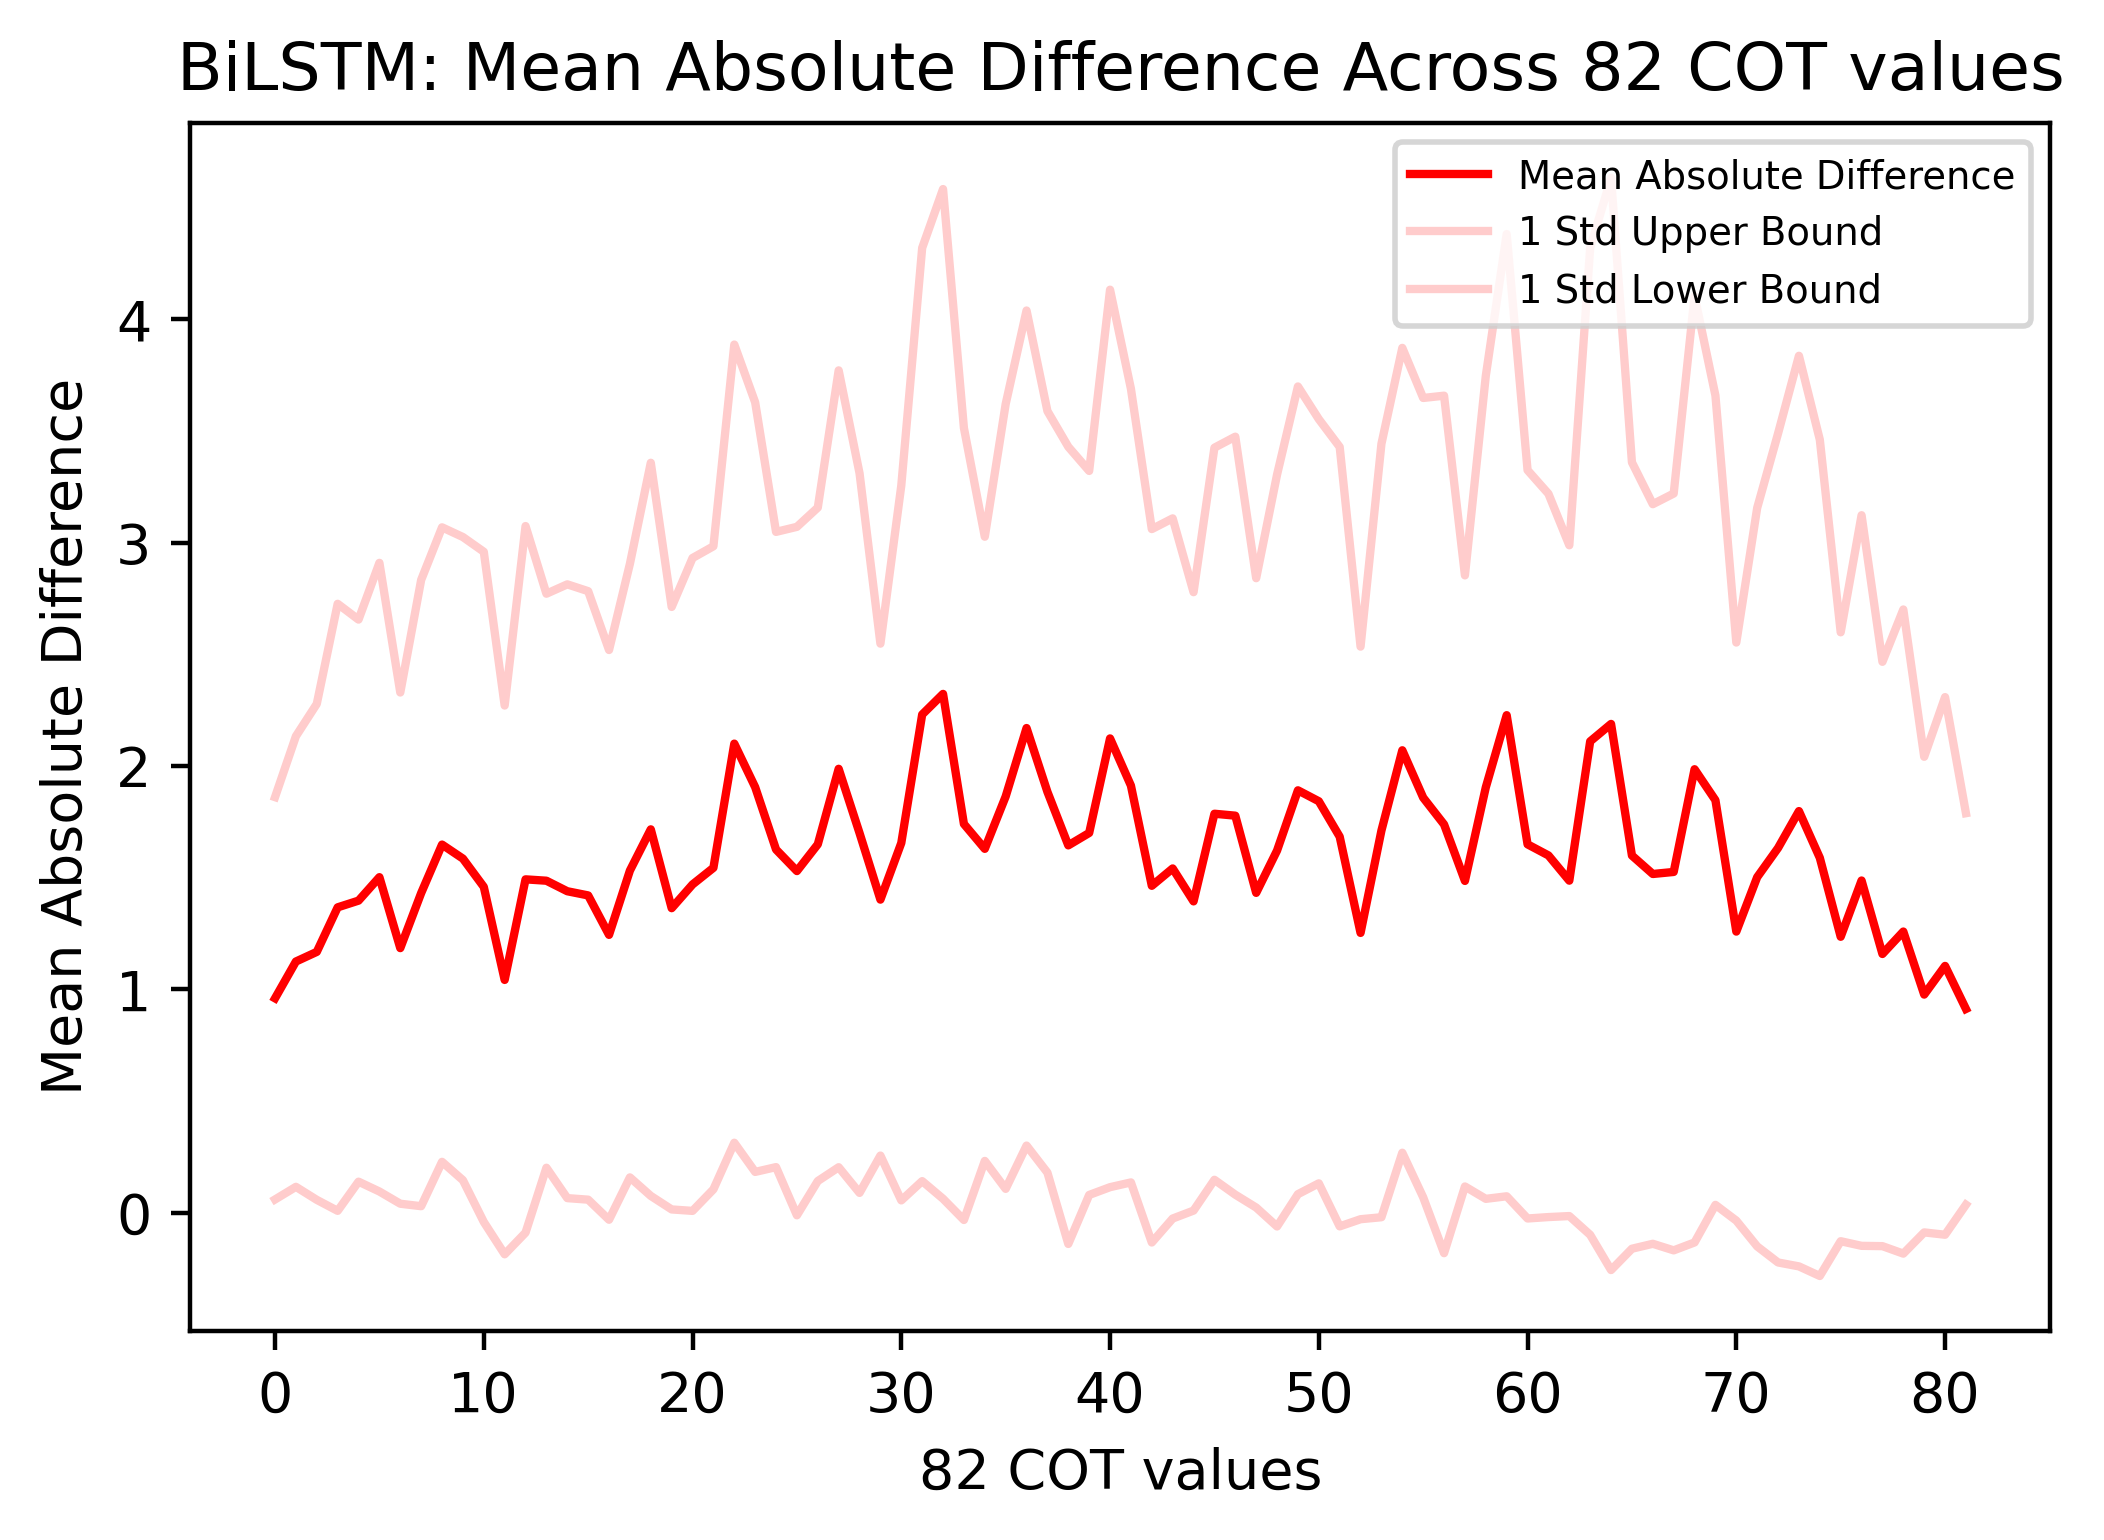

In [48]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/v1-BiLSTM_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

# Physics Method 

# Test set comparison: mse and rmse 

In [103]:
#after shuffle, the last 800 profiles in cot_data are test set
test_lb= cot_data[3200:4000]
test_lb.shape

(800, 4096)

In [107]:
#find which profiles are in test_lb

corresponding_1d=[]
for i in range(800):
    for j in range(4000):
        fname = "D:\\code\\Fiona\\climate project\\New Data\\retrieved_COT/profile_%05d.hdf5"%(j+1)
        hf = h5py.File(fname, 'r')
        cot=np.array(hf.get('tau')) #ground truth
        equal=np.array_equal(test_lb[i],cot) #find which profiles are in test_lb
        if equal is True:
            print(fname)
            corresponding_1d.append(fname)

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00116.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00289.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03770.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03335.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01182.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00338.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03482.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02688.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03061.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00047.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00748.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03668.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03208.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_007

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01706.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02882.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03293.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00595.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02988.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01334.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02215.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03878.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01552.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03350.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03318.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01543.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03407.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_003

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02404.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00293.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00699.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01049.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03701.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03201.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02418.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03870.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03905.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01668.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01964.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01250.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02275.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_012

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00787.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00874.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00740.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02868.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03292.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03506.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01007.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01845.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00587.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01307.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02990.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00349.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02472.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_010

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03420.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01401.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03915.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01393.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02258.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02178.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02238.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00137.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01471.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03153.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01279.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01974.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00895.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_001

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01914.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00957.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01489.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00026.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01135.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02198.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00926.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03225.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01553.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02745.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00844.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01646.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02938.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_035

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02768.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02840.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03003.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03300.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01685.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01168.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02025.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01205.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02917.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_00973.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_01156.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02037.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_03947.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_010

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02608.hdf5
D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02733.hdf5


In [118]:
len(corresponding_1d)

800

In [114]:
#test if there are duplicate profiles 
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    print(len(unique_list))

In [115]:
#all the profiles are unique in corresponding 1d retrieval
unique(corresponding_1d)

800


In [122]:
one_d_retrieval=np.empty((800,4096), dtype=float)

for i in range(800):
    fname=corresponding_1d[i]
    hf = h5py.File(fname, 'r')
    a=np.array(hf.get('Retrieved_tau'))#1D retrieval
    one_d_retrieval[i]=a

In [124]:
#MSE RMSE for 1D retreival by test set (800 profiles)

from sklearn.metrics import mean_squared_error
import math
# Calculation of Mean Squared Error (MSE)
#mse=mean_squared_error(Y_true,Y_pred)

mse=mean_squared_error(test_lb,one_d_retrieval)
rmse = math.sqrt(mse)

print('1D retrieval MSE:',mse)
print('1D retrieval RMSE:',rmse)

1D retrieval MSE: 130.5281209194181
1D retrieval RMSE: 11.424890411702778


# Entire dataset comparison

In [10]:
#COT dataset
cot_data1=np.empty((4000,4096),dtype=float)
for i in range(0,4000):#4000
    fname = "D:\\code\\Fiona\\climate project\\New Data\\profiles/profile_%05d.hdf5"%(i+1)
    hf = h5py.File(fname, 'r')
    cot=np.array(hf.get('tau'))
    cot_data1[i]=cot
    hf.close()

In [11]:
one_d_retrieval_entire=np.empty((4000,4096), dtype=float)
for i in range(0,4000):#4000
    fname = "D:\\code\\Fiona\\climate project\\New Data\\retrieved_COT/profile_%05d.hdf5"%(i+1)
    hf = h5py.File(fname, 'r')
    a=np.array(hf.get('Retrieved_tau'))
    one_d_retrieval_entire[i]=a
    hf.close()

In [14]:
#MSE RMSE for 1D retreival for entire COT dataset and corresponding 1D retrieval (4000 profiles)
from sklearn.metrics import mean_squared_error
import math
mse=mean_squared_error(cot_data1,one_d_retrieval_entire)
rmse = math.sqrt(mse)

In [15]:
print('1D retrieval MSE:',mse)
print('1D retrieval RMSE:',rmse)

1D retrieval MSE: 126.59652562760502
1D retrieval RMSE: 11.25151214848942


# Finding out which profiles are the last three profiles in testset

In [26]:
for i in range(0,num):#4000
    fname = c[i]
    #hf = h5py.File(fname, 'r')
   # cot = np.array(hf.get("tau"))
    equal=np.array_equal(fname,c[num-3]) #3rd last profile
    if equal is True:
        print(i)
        print(fname)

3997
[ 9.19440786  9.59398037 14.35442831 18.64310505 13.32939178 11.00313015
  8.61502076  7.74891274  7.56773302  5.2716958   3.37034791  2.58012404
  4.35974952  5.64018178  4.20961618  6.26649606  7.89280609  8.55528198
  6.1017566   4.52975518  3.78536456  3.31148658  4.02461109  2.97183399
  2.12723636  1.62672217  1.80867788  2.4006211   1.88991543  1.12418498
  1.99481746  5.51593328  3.74048033  5.44516433  5.8769492   7.4876137
  4.65934373  3.46729558  2.71697314  2.43391475  3.49909391  6.71141674
  6.40677719  4.30480721  3.5567763   4.56976393  8.55637681  9.67886097
 10.41294371  6.64986363  7.86499398 10.11460697 10.44813858 13.67914747
  9.3650009   6.11384225 16.82215311 23.13865887 16.4082855  14.56776581
 13.27341182  8.09387665 10.31288206 10.30505748 12.04492646 16.59946003
 15.80946771 23.13986964 28.36561845 18.83213141 15.10670088 23.06001967
 39.72561261 58.57947461 34.63429517 32.30097065 27.49721521 23.12313677
 32.64443278 26.35709699 16.32918813 16.6943697

In [28]:

physics_retrieval03997 = c[3997]
physics_retrieval03997

array([ 9.19440786,  9.59398037, 14.35442831, 18.64310505, 13.32939178,
       11.00313015,  8.61502076,  7.74891274,  7.56773302,  5.2716958 ,
        3.37034791,  2.58012404,  4.35974952,  5.64018178,  4.20961618,
        6.26649606,  7.89280609,  8.55528198,  6.1017566 ,  4.52975518,
        3.78536456,  3.31148658,  4.02461109,  2.97183399,  2.12723636,
        1.62672217,  1.80867788,  2.4006211 ,  1.88991543,  1.12418498,
        1.99481746,  5.51593328,  3.74048033,  5.44516433,  5.8769492 ,
        7.4876137 ,  4.65934373,  3.46729558,  2.71697314,  2.43391475,
        3.49909391,  6.71141674,  6.40677719,  4.30480721,  3.5567763 ,
        4.56976393,  8.55637681,  9.67886097, 10.41294371,  6.64986363,
        7.86499398, 10.11460697, 10.44813858, 13.67914747,  9.3650009 ,
        6.11384225, 16.82215311, 23.13865887, 16.4082855 , 14.56776581,
       13.27341182,  8.09387665, 10.31288206, 10.30505748, 12.04492646,
       16.59946003, 15.80946771, 23.13986964, 28.36561845, 18.83

In [39]:
fname = "D:\\code\\Fiona\\climate project\\New Data\\retrieved_COT/profile_01654.hdf5"
hf = h5py.File(fname, 'r')
physics_retrieval01654 = np.array(hf.get("Retrieved_tau"))

In [158]:
for i in range(0,num):#4000
    fname = "D:\\code\\Fiona\\climate project\\New Data\\retrieved_COT/profile_%05d.hdf5"%(i+1)
    hf = h5py.File(fname, 'r')
    cot = np.array(hf.get("tau"))
    equal=np.array_equal(cot,cot_data[num-2])
    if equal is True:
        print(fname)

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02608.hdf5


In [40]:
fname = 'D:\\code\\Fiona\\climate project\\New Data\\retrieved_COT/profile_02608.hdf5'
hf = h5py.File(fname, 'r')
physics_retrieval02608 = np.array(hf.get("Retrieved_tau"))

In [159]:
for i in range(0,num):#4000
    fname = "D:\\code\\Fiona\\climate project\\New Data\\retrieved_COT/profile_%05d.hdf5"%(i+1)
    hf = h5py.File(fname, 'r')
    cot = np.array(hf.get("tau"))
    equal=np.array_equal(cot,cot_data[num-1])
    if equal is True:
        print(fname)

D:\code\Fiona\climate project\New Data\retrieved_COT/profile_02733.hdf5


In [41]:
fname ='D:\\code\\Fiona\\climate project\\New Data\\retrieved_COT/profile_02733.hdf5'
hf = h5py.File(fname, 'r')
physics_retrieval02733 = np.array(hf.get("Retrieved_tau"))

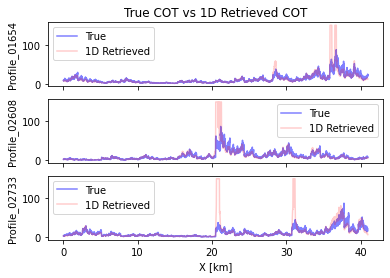

In [161]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/predict_Bi-LSTM SZA=60 VZA=0 1D retrieval comparison"

fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"True COT vs 1D Retrieved COT")
ax.plot(x[edge:os*l2r+edge],cot_data[num-3,:os*l2r],alpha=0.5,color="blue") #ground truth
ax.plot(x[edge:os*l2r+edge],physics_retrieval01654,alpha=0.2,color="red") 
ax.legend(["True", "1D Retrieved"])
ax.set_ylabel(r"Profile_01654") 

#plot the second last profile
ax = axs[1]
ax.plot(x[edge:os*l2r+edge],cot_data[num-2,edge:os*l2r+edge],alpha=0.5,color="blue")
ax.plot(x[edge:os*l2r+edge],physics_retrieval02608,alpha=0.2,color="red")
ax.legend(["True", "1D Retrieved"])
ax.set_ylabel(r"Profile_02608")  

# plot the last profile
ax = axs[2]
ax.plot(x[edge:os*l2r+edge],cot_data[num-1,edge:os*l2r+edge].T,alpha=0.5,color="blue")
ax.plot(x[edge:os*l2r+edge],physics_retrieval02733,alpha=0.2,color="red")
ax.legend(["True", "1D Retrieved"])
ax.set_ylabel(r"Profile_02733")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm)

# Comparison between 3D retrieval and 1D retrieval(SZA=60 VZA=0) and 1D retrieval(multi-SZA multi-VZA)

In [190]:
fname = "D:\\code\\Fiona\\climate project\\New Data\\monday_retrievals/profile_01654.hdf5"
hf = h5py.File(fname, 'r')
physics_retrieval01654_multi = np.array(hf.get("Retrieved_tau"))
cot=np.array(hf.get("tau"))

In [191]:
hf.keys()

<KeysViewHDF5 ['Retrieved_tau', 'lwp', 're', 'tau', 'x_distance', 'y']>

In [200]:
physics_retrieval01654_multi[5,5,:]

array([ 8.04395604,  8.04395604,  7.45054945, ..., 13.40659341,
       12.13186813, 11.75824176])

In [201]:
physics_retrieval01654

array([ 8.04395604,  8.04395604,  7.45054945, ..., 13.40659341,
       12.13186813, 11.75824176])

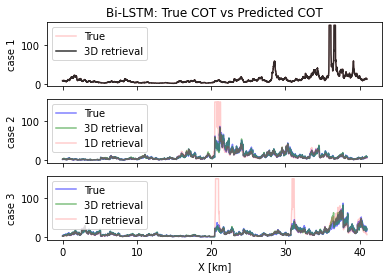

In [199]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/predict_Bi-LSTM SZA=60 VZA=0"+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM: True COT vs Predicted COT")
#ax.plot(x[edge:os*l2r+edge],cot_data[num-3,:os*l2r],alpha=0.5,color="blue") #ground truth
#ax.plot(x[edge:os*l2r+edge],predict1.reshape(4096),alpha=0.5,color="green") 
ax.plot(x[edge:os*l2r+edge],physics_retrieval01654,alpha=0.2,color="red") 
ax.plot(x[edge:os*l2r+edge],physics_retrieval01654_multi[5,5,:],alpha=0.8,color="black") 

ax.legend(["True", "3D retrieval",'1D retrieval single-angle','1D retrieval multi-angle'])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[edge:os*l2r+edge],cot_data[num-2,edge:os*l2r+edge],alpha=0.5,color="blue")
ax.plot(x[edge:os*l2r+edge],predict2.reshape(4096),alpha=0.5,color="green")
ax.plot(x[edge:os*l2r+edge],physics_retrieval02608,alpha=0.2,color="red")
ax.legend(["True", "3D retrieval",'1D retrieval'])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[edge:os*l2r+edge],cot_data[num-1,edge:os*l2r+edge].T,alpha=0.5,color="blue")
ax.plot(x[edge:os*l2r+edge],predict3.reshape(4096),alpha=0.5,color="green")
ax.plot(x[edge:os*l2r+edge],physics_retrieval02733,alpha=0.2,color="red")
ax.legend(["True", "3D retrieval",'1D retrieval'])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')